# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading
2. Dictionary generation
3. Data preprocessing
4. Model (neural network) training
5. Text generation (model evaluation)

### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

**Alternatively**

You could use file `onegin.txt` with Russian texts or your natve language poetry to be able to assess results quality.

**Note: In case of Onegin text you need to adjust reading procedure yourself!!!** (this file has a bit different format than `sonnets.txt`)

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from random import sample
from IPython.display import clear_output
import re
from typing import Optional, Sequence

In [2]:
with open("sonnets.txt", "r") as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START:TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
import string

In [4]:
roman_numeral_pattern = re.compile(r'^\s*[IVXLCDM]+\s*$')

poems = []
stanza = []

for line in text:
    stripped_line = line.strip()
    if stripped_line and not roman_numeral_pattern.match(stripped_line):
        stanza.append(stripped_line)
    elif not stripped_line and stanza:
        poems.append(stanza)
        stanza = []

if stanza:
    poems.append(stanza)

print(poems[0])

['From fairest creatures we desire increase,', "That thereby beauty's rose might never die,", 'But as the riper should by time decease,', 'His tender heir might bear his memory:', 'But thou, contracted to thine own bright eyes,', "Feed'st thy light's flame with self-substantial fuel,", 'Making a famine where abundance lies,', 'Thy self thy foe, to thy sweet self too cruel:', "Thou that art now the world's fresh ornament,", 'And only herald to the gaudy spring,', 'Within thine own bud buriest thy content,', "And tender churl mak'st waste in niggarding:", 'Pity the world, or else this glutton be,', "To eat the world's due, by the grave and thee."]


In [5]:
len(poems)

154

In [6]:
import spacy

nlp = spacy.load("en_core_web_sm")
def lemmatize_stanza(stanza):
    lemmatized = []
    for line in stanza:
        doc = nlp(line)
        lemmatized.extend([token.lemma_ for token in doc if not token.is_punct and not token.is_space])
        lemmatized.append('\n')
    return lemmatized

In [7]:
lemmatized_poems = [lemmatize_stanza(stanza) for stanza in poems]

In [8]:
print(lemmatized_poems[0])

['from', 'fairest', 'creature', 'we', 'desire', 'increase', '\n', 'that', 'thereby', 'beauty', "'s", 'rose', 'might', 'never', 'die', '\n', 'but', 'as', 'the', 'riper', 'should', 'by', 'time', 'decease', '\n', 'his', 'tender', 'heir', 'might', 'bear', 'his', 'memory', '\n', 'but', 'thou', 'contract', 'to', 'thine', 'own', 'bright', 'eye', '\n', "Feed'st", 'thy', 'light', "'s", 'flame', 'with', 'self', 'substantial', 'fuel', '\n', 'make', 'a', 'famine', 'where', 'abundance', 'lie', '\n', 'thy', 'self', 'thy', 'foe', 'to', 'thy', 'sweet', 'self', 'too', 'cruel', '\n', 'thou', 'that', 'art', 'now', 'the', 'world', "'s", 'fresh', 'ornament', '\n', 'and', 'only', 'herald', 'to', 'the', 'gaudy', 'spring', '\n', 'within', 'thine', 'own', 'bud', 'buri', 'thy', 'content', '\n', 'and', 'tender', 'churl', "mak'st", 'waste', 'in', 'niggarde', '\n', 'pity', 'the', 'world', 'or', 'else', 'this', 'glutton', 'be', '\n', 'to', 'eat', 'the', 'world', "'s", 'due', 'by', 'the', 'grave', 'and', 'thee', '\n

In [9]:
wrapped_poems = [[[word] for word in stanza] for stanza in lemmatized_poems]

print(wrapped_poems[0])
print(len(wrapped_poems))

[['from'], ['fairest'], ['creature'], ['we'], ['desire'], ['increase'], ['\n'], ['that'], ['thereby'], ['beauty'], ["'s"], ['rose'], ['might'], ['never'], ['die'], ['\n'], ['but'], ['as'], ['the'], ['riper'], ['should'], ['by'], ['time'], ['decease'], ['\n'], ['his'], ['tender'], ['heir'], ['might'], ['bear'], ['his'], ['memory'], ['\n'], ['but'], ['thou'], ['contract'], ['to'], ['thine'], ['own'], ['bright'], ['eye'], ['\n'], ["Feed'st"], ['thy'], ['light'], ["'s"], ['flame'], ['with'], ['self'], ['substantial'], ['fuel'], ['\n'], ['make'], ['a'], ['famine'], ['where'], ['abundance'], ['lie'], ['\n'], ['thy'], ['self'], ['thy'], ['foe'], ['to'], ['thy'], ['sweet'], ['self'], ['too'], ['cruel'], ['\n'], ['thou'], ['that'], ['art'], ['now'], ['the'], ['world'], ["'s"], ['fresh'], ['ornament'], ['\n'], ['and'], ['only'], ['herald'], ['to'], ['the'], ['gaudy'], ['spring'], ['\n'], ['within'], ['thine'], ['own'], ['bud'], ['buri'], ['thy'], ['content'], ['\n'], ['and'], ['tender'], ['churl

In [10]:
text = wrapped_poems

In [11]:
tokens = {word: idx for idx, word in enumerate(set(word for stanza in lemmatized_poems for word in stanza))}

In [12]:
len(tokens)

2661

In [13]:
lengths = list(map(len, text))
MAX_LENGTH = max(lengths)

Put all the characters, that you've seen in the text, into variable `tokens`.

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [14]:
# dict <index>:<char>
# Your great code here

# dict <char>:<index>
# Your great code here
PAD_TOKEN = "\n"
# END_TOKEN = "\n"

token_to_idx = {char: idx for idx, char in enumerate(tokens)}
idx_to_token = {idx: char for idx, char in enumerate(tokens)}

In [15]:
def text_to_matrix(
    names: Sequence[str],
    max_len: Optional[int] = None,
    pad: int = token_to_idx[PAD_TOKEN],
    dtype=np.int64,
    batch_first: bool = True,
):
    max_len = max_len or max(map(len, names))
    text_idx = np.full((len(names), MAX_LENGTH), pad, np.int64)

    for i, word in enumerate(names):
        line_ix = [token_to_idx[char[0]] for char in word]
        text_idx[i, : len(line_ix)] = line_ix


    return text_idx

In [16]:
text_idx = np.full((len(text), MAX_LENGTH), token_to_idx[PAD_TOKEN], np.int64)

for i, word in enumerate(text):
    line_ix = [token_to_idx[char[0]] for char in word]
    text_idx[i, : len(line_ix)] = line_ix

In [17]:
print(text_to_matrix(text))

[[ 322 1834   90 ...   48   48   48]
 [2617 1359  860 ...   48   48   48]
 [2649 1454  152 ...   48   48   48]
 ...
 [1454 1478 2282 ...   48   48   48]
 [2132 2579 1446 ...   48   48   48]
 [ 717  933 1478 ...   48   48   48]]


In [18]:
print(text_to_matrix(text)[-1])

[ 717  933 1478 1916  109 2628  925   48 2579 1446 1676 2420 1676 1526
 2600  392   48  616 1812 1329 1428 1937  442  524  727  391   48 2346
 1039 1446 1204 1454  406  834 2351   48  717 1834  748  253  567 1428
 1424   48 1977 1812 1076 1277 2378 1526 1882  626   48  394 2243  717
  180 1277 1842  894   48 2233 1531 1446  217  904 2351  115   48 2376
  392  210 1038 1454  217 1003  458 1446   48 1977  322  311 1831 1424
  253 2055  795   48  159  217  251  394 2455 2395   48 1838 1348  840
 1204 1943  928 2141  650   48   35  776 1838 1381  394 2376 1446 1428
 1943 2228   48 1478 1831 1424 2055 2635 2635 1003  339 1478   48   48
   48   48   48   48   48   48   48   48   48   48   48   48   48   48
   48   48   48   48   48   48]


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [19]:
emb_size = 4

In [20]:
Embedding = nn.Embedding(len(tokens), emb_size)

In [21]:
matrix_text = text_to_matrix(text)
batch = torch.from_numpy(matrix_text).type(torch.int64)
emb = Embedding(batch)

In [22]:
emb.shape

torch.Size([154, 146, 4])

In [23]:
batch.size()

torch.Size([154, 146])

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
class CharRNNCell(nn.Module):
    """Implement the scheme above as torch module"""

    def __init__(self, num_tokens=len(tokens), embedding_size=emb_size, rnn_num_units=16):
        super().__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        # batch, seq leng, emb dim
        x_emb = self.embedding(x)

        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)

        h_next = torch.tanh(h_next)

        # compute logits for next character probs
        logits = self.rnn_to_logits(h_next)

        return h_next, logits

    def initial_state(self, batch_size):
        """return rnn state before it processes first input (aka h0)"""
        # TODO init with normal distribution and make it trainable
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [26]:
char_rnn = CharRNNCell().to(device)
criterion = nn.NLLLoss()

In [27]:
def rnn_loop(char_rnn, batch_ix):
    batch_ix = batch_ix.to(device)
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size).to(device)
    logprobs = []

    for x_t in batch_ix.transpose(0, 1):
        hid_state, logits = char_rnn(x_t, hid_state)
        logprobs.append(F.log_softmax(logits, -1))

    return torch.stack(logprobs, dim=1)

In [28]:
batch_ix = text_to_matrix(text)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
print(batch_ix.shape)

logp_seq = rnn_loop(char_rnn, batch_ix)
logp_seq.shape

torch.Size([154, 146])


torch.Size([154, 146, 2661])

In [29]:
predictions_logp = logp_seq[:, :-1].to(device)
actual_next_tokens = batch[:, 1:].to(device)

# .contiguous() method checks that tensor is stored in the memory correctly to
# get its view of desired shape.

loss = criterion(
    predictions_logp.contiguous().view(-1, len(tokens)),
    actual_next_tokens.contiguous().view(-1),
)

loss.backward()

In [30]:
def calculate_accuracy(predictions, targets, device='cuda'): 
    predictions = predictions.to(device)
    targets = targets.to(device)
    
    pred_inds = torch.argmax(predictions, dim=-1)
    accuracy = (pred_inds == targets).sum().item() / targets.numel()
    return accuracy


In [33]:
char_rnn = CharRNNCell().to(device)
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
batch_size = 2
num_iterations = 500
num_epochs = 10

history_loss = []
history_acc = []

for epoch in range(num_epochs):
    print(epoch)
    epoch_loss = 0
    epoch_accuracy = 0
    for i in range(num_iterations):
        opt.zero_grad()

        batch_ix = text_to_matrix(sample(text, batch_size))
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)

        logp_seq = rnn_loop(char_rnn, batch_ix)

        predictions_logp = logp_seq[:, :-1].to(device)
        actual_next_tokens = batch_ix[:, 1:].to(device)

        loss = criterion(
            predictions_logp.contiguous().view(-1, len(tokens)),
            actual_next_tokens.contiguous().view(-1)
        )

        loss.backward()
        opt.step()
        epoch_loss += loss.item()

        accuracy = calculate_accuracy(predictions_logp, actual_next_tokens, device=device)
        epoch_accuracy += accuracy

        if i % 100 == 0:
            print(f"Iteration {i}/{num_iterations}")

    avg_epoch_loss = epoch_loss / num_iterations
    avg_epoch_accuracy = epoch_accuracy / num_iterations
    history_loss.append(avg_epoch_loss)
    history_acc.append(avg_epoch_accuracy)


0
Iteration 0/500
Iteration 100/500
Iteration 200/500
Iteration 300/500
Iteration 400/500
1
Iteration 0/500
Iteration 100/500
Iteration 200/500
Iteration 300/500
Iteration 400/500
2
Iteration 0/500
Iteration 100/500
Iteration 200/500
Iteration 300/500
Iteration 400/500
3
Iteration 0/500
Iteration 100/500
Iteration 200/500
Iteration 300/500
Iteration 400/500
4
Iteration 0/500
Iteration 100/500
Iteration 200/500
Iteration 300/500
Iteration 400/500
5
Iteration 0/500
Iteration 100/500
Iteration 200/500
Iteration 300/500
Iteration 400/500
6
Iteration 0/500
Iteration 100/500
Iteration 200/500
Iteration 300/500
Iteration 400/500
7
Iteration 0/500
Iteration 100/500
Iteration 200/500
Iteration 300/500
Iteration 400/500
8
Iteration 0/500
Iteration 100/500
Iteration 200/500
Iteration 300/500
Iteration 400/500
9
Iteration 0/500
Iteration 100/500
Iteration 200/500
Iteration 300/500
Iteration 400/500


Plot the loss function (axis X: number of epochs, axis Y: loss function).

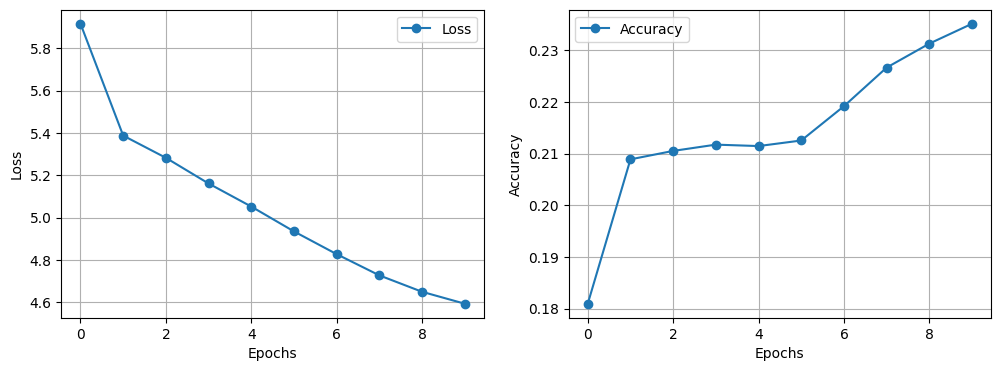

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history_loss, marker='o', label="Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history_acc, marker='o', label="Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True)
axes[1].legend()

plt.show()

In [136]:
def generate_sample(char_rnn, seed_phrase, max_length=50, temperature=0.2):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    """
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64, device=device)
    hid_state = char_rnn.initial_state(batch_size=1).to(device) 

    # feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

    # start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits / temperature, dim=-1).data.cpu().numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64, device=device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ' '.join([idx_to_token[ix] for ix in x_sequence.data.cpu().numpy()[0]])

In [138]:
print(generate_sample(char_rnn, seed_phrase=["from"], temperature=0.8))

from therein loving 
 and constant angel not be that have perfume 
 thus I heart it alone before be 
 nor the reason I be a have thou day 
 for not in from thee 
 nor time the feature 
 when I in shadow other 's invent a


In [149]:
def generate_multiple_samples(char_rnn, seed_phrase, num_lines=2, max_length=50, temperature=0.2):

    results = []
    current_seed = seed_phrase
    
    for _ in range(num_lines):
        x_sequence = [token_to_idx[token] for token in current_seed]
        x_sequence = torch.tensor([x_sequence], dtype=torch.int64, device=device)
        hid_state = char_rnn.initial_state(batch_size=1).to(device)
        
        for i in range(len(current_seed) - 1):
            hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
        
        for _ in range(max_length - len(current_seed)):
            hid_state, logits = char_rnn(x_sequence[:, -1], hid_state)
            p_next = F.softmax(logits / temperature, dim=-1).data.cpu().numpy()[0]
            next_ix = np.random.choice(len(tokens), p=p_next)
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64, device=device)
            x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
        vec_line = [idx_to_token[ix] for ix in x_sequence.data.cpu().numpy()[0]]
        last_word = next(word for word in reversed(vec_line) if word)
        current_seed = [last_word]
        vec_line.remove(last_word)
        generated_line = ' '.join(vec_line)
        results.append(generated_line)

    return '\n'.join(results)


In [150]:
print(generate_multiple_samples(char_rnn, seed_phrase=["from"], temperature=0.8))

from dead be devis'd be a decrepit 's here 
 be I 's soul that I thou summer 
 sland're to Time in invite 
 as I fast o reason that say be by do 
 when in thou praise 
 the forward guilt shall man to from my
time jaw 
 
 
 
 
 can every impediment 
 gainst worthy salve till approve I have description new and I tyrant 
 that this that blessed on lie 
 then world be his my prognosticate then despite my love 
 and to my body near of the


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [161]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=8, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.num_units = rnn_num_units

    def forward(self, x):
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

    def forward_char(self, x, h=None):
        if h is None:
            out, h = self.rnn(self.emb(x))
        else:
            out, h = self.rnn(self.emb(x), h)
        out = self.hid_to_logits(out)
        return out, h

    def initial_state(self, batch_size):
        """return rnn state before it processes first input (aka h0)"""
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [162]:
model = CharRNNLoop().to(device)
opt = torch.optim.Adam(model.parameters())
history = []

# the model applies over the whole sequence
batch_ix = text_to_matrix(sample(text, 32), max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix).to(device)

In [163]:
logp_seq = model(batch_ix)

loss = criterion(
    logp_seq[:, :-1].contiguous().view(-1, len(tokens)), batch_ix[:, 1:].contiguous().view(-1)
)

loss.backward()

In [164]:
model = CharRNNLoop().to(device)
criterion = nn.NLLLoss()
opt = torch.optim.Adam(model.parameters())
batch_size = 2
num_iterations = 2000
num_epochs = 10

history_loss = []
history_acc = []

for epoch in range(num_epochs):
    print(epoch)
    epoch_loss = 0
    epoch_accuracy = 0
    for i in range(num_iterations):
        opt.zero_grad()

        batch_ix = text_to_matrix(sample(text, batch_size))
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)

        logp_seq = model(batch_ix)

        predictions_logp = logp_seq[:, :-1].to(device)
        actual_next_tokens = batch_ix[:, 1:].to(device)

        loss = criterion(
            predictions_logp.contiguous().view(-1, len(tokens)), actual_next_tokens.contiguous().view(-1)
        )

        # train with backprop
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
        accuracy = calculate_accuracy(predictions_logp, actual_next_tokens, device=device)
        epoch_accuracy += accuracy

    avg_epoch_loss = epoch_loss / num_iterations
    avg_epoch_accuracy = epoch_accuracy / num_iterations
    history_loss.append(avg_epoch_loss)
    history_acc.append(avg_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9


Plot the loss function of the number of epochs. Does the final loss become better?

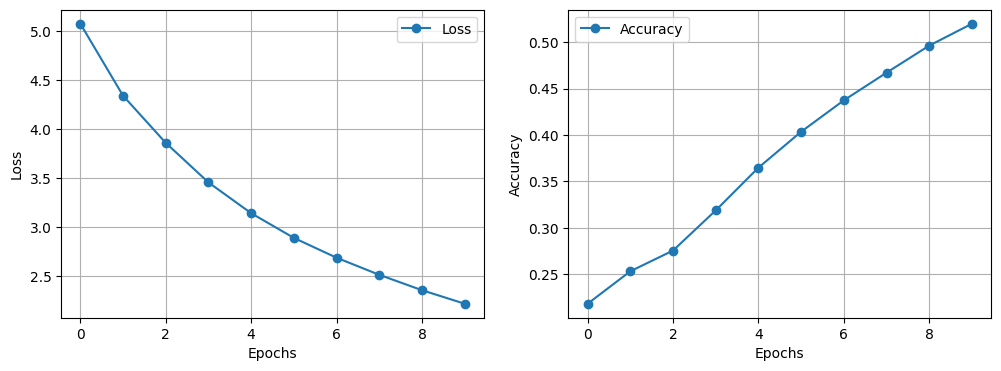

In [165]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history_loss, marker='o', label="Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history_acc, marker='o', label="Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True)
axes[1].legend()

plt.show()

Generate text using the trained net with different `temperature` parameter: `(0.1, 0.2, 0.5, 1.0, 2.0)`.

Evaluate the results visually, try to interpret them.

In [174]:
def generate_sample_lstm(
    char_rnn, seed_phrase, max_length=50, temperature=1.0, device='cuda'
):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    # feed the seed phrase, if any
    logits, h = char_rnn.forward_char(x_sequence)
    logits = logits[:, -1]

    # start generating
    for _ in range(max_length - x_sequence.shape[1] + 1):
        p_next = F.softmax(logits / temperature, dim=-1).cpu().data.numpy().squeeze()

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        logits, h = char_rnn.forward_char(next_ix, h)

    return ' '.join([idx_to_token[ix] for ix in x_sequence.data.cpu().numpy()[0]])

In [179]:
print(generate_sample_lstm(model, seed_phrase=["from"], temperature=0.8))

from chase thee when thou day 
 how thou wilt as mourn doth I be not acquaint 
 a self and beauty and spur can not love be so bold 
 which be not steal thy beauty will new 
 or sweet seem will no bare I have remov'd by short


In [185]:
temps = [0.1, 0.2, 0.5, 1.0, 2.0]

for temp in temps:
    print(temp)
    print(generate_sample_lstm(model, seed_phrase=["from"], temperature=temp))

0.1
from fairest creature nor ne'er summer 's brain and summer asleep rage rage rage 
 but try beast wire state with figure 
 when that tomb that I abide 
 the world and fill'd by day oppress'd 
 and in my madness might be so fair be most 
 and thou
0.2
from fairest creature I never rage 's hand hasten 
 Whereon the beauty blunt in dream 's scope 
 but be profan'd thee and day and unfather'd 
 and maiden particular be term'd my heart do 
 and all my honest faith be so bold 
 to linger on a pure
0.5
from fairest creature but my mind want I come forsake again 
 Wilt thou wilt thou lov'st to this purpose mayst be 
 I have say your beauty be mute with thine 
 and that beauty 's bastard be lov'd the prime knife 
 and the firm soil own pay to
1.0
from fairest creature as one I view 
 ah like the marigold of fault beauty dead 
 Desire thought but fear of worm of thine I 
 and both black on second a seat so bright 
 or if they themselves not and give it bar 
 now as it base
2.0
from his appeti

При использовании LSTM среднее значение loss на эпохе ниже чем при vanila RNN, и среднее значение accuracy на эпохе лучше у LSTM

Значение temperature влияет на "консервативность" модели.

### Saving and loading models

Save the model to the disk, then load it and generate text.
Follow guides from [this tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

You need to use `Save/Load state_dict (Recommended)` section aka save state dict.

In [186]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

emb.weight 	 torch.Size([2661, 8])
rnn.weight_ih_l0 	 torch.Size([256, 8])
rnn.weight_hh_l0 	 torch.Size([256, 64])
rnn.bias_ih_l0 	 torch.Size([256])
rnn.bias_hh_l0 	 torch.Size([256])
hid_to_logits.weight 	 torch.Size([2661, 64])
hid_to_logits.bias 	 torch.Size([2661])


In [187]:
print("Optimizer's state_dict:")
for var_name in opt.state_dict():
    print(var_name, "\t", opt.state_dict()[var_name])

Optimizer's state_dict:
state 	 {0: {'step': tensor(20000.), 'exp_avg': tensor([[ 2.1070e-08,  1.7803e-08, -5.6203e-07,  ...,  4.6206e-08,
         -2.4449e-07, -4.3554e-07],
        [-1.9929e-07,  7.0496e-07,  4.5384e-08,  ...,  3.3819e-07,
          1.6341e-07,  2.0006e-07],
        [-2.1584e-09,  4.3632e-10,  2.6611e-09,  ...,  4.2781e-11,
         -1.2763e-09,  1.6992e-11],
        ...,
        [ 4.5500e-05,  4.3310e-05, -2.0552e-05,  ..., -1.0041e-05,
          1.1345e-05,  4.1698e-05],
        [-2.6775e-05,  1.8658e-05, -3.6378e-05,  ..., -1.5957e-05,
          1.5794e-05, -1.0781e-05],
        [-9.9949e-08,  2.0423e-07,  2.2920e-07,  ..., -7.6140e-08,
         -7.9589e-08, -4.1785e-08]], device='cuda:0'), 'exp_avg_sq': tensor([[8.1936e-09, 1.3793e-09, 8.6620e-08,  ..., 4.6680e-08, 7.2488e-09,
         5.6700e-08],
        [3.6935e-07, 1.1222e-06, 5.3530e-07,  ..., 8.9201e-07, 3.5409e-07,
         1.7174e-07],
        [2.7190e-07, 9.0588e-09, 1.4640e-07,  ..., 1.6060e-09, 1.2670e

In [188]:
PATH = 'D:\GitHub\WorkSpace\AI_HUB_ML-DL\model_dict_lstm'
torch.save(model.state_dict(), PATH)

<>:1: SyntaxWarning: invalid escape sequence '\G'
<>:1: SyntaxWarning: invalid escape sequence '\G'
C:\Users\alshe\AppData\Local\Temp\ipykernel_40612\1424886833.py:1: SyntaxWarning: invalid escape sequence '\G'
  PATH = 'D:\GitHub\WorkSpace\AI_HUB_ML-DL\model_dict_lstm'


In [189]:
model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [190]:
model.eval()

CharRNNLoop(
  (emb): Embedding(2661, 8)
  (rnn): LSTM(8, 64, batch_first=True)
  (hid_to_logits): Linear(in_features=64, out_features=2661, bias=True)
)

## Additional materials on topic

1. [Andrew Karpathy blog post about RNN.](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)\
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with [PyTorch examples](https://github.com/spro/practical-pytorch`)